<a href="https://colab.research.google.com/github/palberth/Modelos_y_Metodos_de_Sistemas_Inteligentes/blob/main/Regresion_Precios_Autos_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

np.random.seed(42)
tf.random.set_seed(42)


In [18]:
##url = "https://raw.githubusercontent.com/selva86/datasets/master/UsedCars.csv"

df = pd.read_csv("/content/used_cars_dataset_v2.csv", on_bad_lines='skip', encoding='latin-1')

print("Dimensiones:", df.shape)
df.head()


Dimensiones: (14993, 11)


,Brand,model,Year,Age,kmDriven,Transmission,Owner,FuelType,PostedDate,AdditionInfo,AskPrice
0,Honda,City,2001,23,"98,000 km",Manual,second,Petrol,24-Nov,"Honda City v teck in mint condition, valid gen...","1,95,000"
1,Toyota,Innova,2009,15,190000.0 km,Manual,second,Diesel,24-Jul,"Toyota Innova 2.5 G (Diesel) 7 Seater, 2009, D...","3,75,000"
2,Volkswagen,VentoTest,2010,14,"77,246 km",Manual,first,Diesel,24-Nov,"Volkswagen Vento 2010-2013 Diesel Breeze, 2010...","1,84,999"
3,Maruti Suzuki,Swift,2017,7,"83,500 km",Manual,second,Diesel,24-Nov,Maruti Suzuki Swift 2017 Diesel Good Condition,"5,65,000"
4,Maruti Suzuki,Baleno,2019,5,"45,000 km",Automatic,first,Petrol,24-Nov,"Maruti Suzuki Baleno Alpha CVT, 2019, Petrol","6,85,000"


In [19]:
# Clean 'kmDriven' column
df['kmDriven'] = df['kmDriven'].astype(str).str.replace(' km', '').str.replace(',', '')
df['kmDriven'] = pd.to_numeric(df['kmDriven'], errors='coerce')

# Clean 'AskPrice' column
df['AskPrice'] = df['AskPrice'].astype(str).str.replace('â\x82¹', '').str.replace(',', '')
df['AskPrice'] = pd.to_numeric(df['AskPrice'], errors='coerce')

# Drop rows with NaN values created by coercion
df.dropna(subset=['kmDriven', 'AskPrice'], inplace=True)

print("Data types after cleaning:")
print(df[['kmDriven', 'AskPrice']].dtypes)
print("\nFirst 5 rows after cleaning:")
print(df[['kmDriven', 'AskPrice']].head())

Data types after cleaning:
kmDriven    float64
AskPrice      int64
dtype: object

First 5 rows after cleaning:
   kmDriven  AskPrice
0   98000.0    195000
1  190000.0    375000
2   77246.0    184999
3   83500.0    565000
4   45000.0    685000


In [20]:
numeric_features = ['Year', 'kmDriven']
categorical_features = ['Brand', 'model', 'FuelType']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
print(df.columns)
X = df[numeric_features + categorical_features]
y = df['AskPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

input_dim = X_train_processed.shape[1]

Index(['Brand', 'model', 'Year', 'Age', 'kmDriven', 'Transmission', 'Owner',
       'FuelType', 'PostedDate', 'AdditionInfo', 'AskPrice'],
      dtype='object')


In [21]:
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        60,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,609 (268.00 KB)

 Trainable params: 68,609 (268.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)

history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3507818070016.0000 - mae: 983996.3750 - val_loss: 3622098173952.0000 - val_mae: 1004648.8750 - learning_rate: 0.0010
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3499316740096.0000 - mae: 980069.3750 - val_loss: 3591898923008.0000 - val_mae: 990849.5625 - learning_rate: 0.0010
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3459561029632.0000 - mae: 961342.1875 - val_loss: 3515677671424.0000 - val_mae: 955320.3750 - learning_rate: 0.0010
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3372884688896.0000 - mae: 919026.6250 - val_loss: 3388558016512.0000 - val_mae: 893323.0000 - learning_rate: 0.0010
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3238571802624.0000 - mae: 850467.2500 - val_loss: 3218193252352.0000 - val_mae: 806253.3750 - learning_rate: 0.0010
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3067425849344.0000 - mae: 759065.4375 - val_loss: 302

In [26]:
# prompt: graficar_historial_entrenamiento_regresion(history)

def graficar_historial_entrenamiento_regresion(history):
    plt.figure(figsize=(12, 6))

    # Gráfico de Loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Historial de Loss (MSE)')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Gráfico de MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Historial de MAE')
    plt.xlabel('Época')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

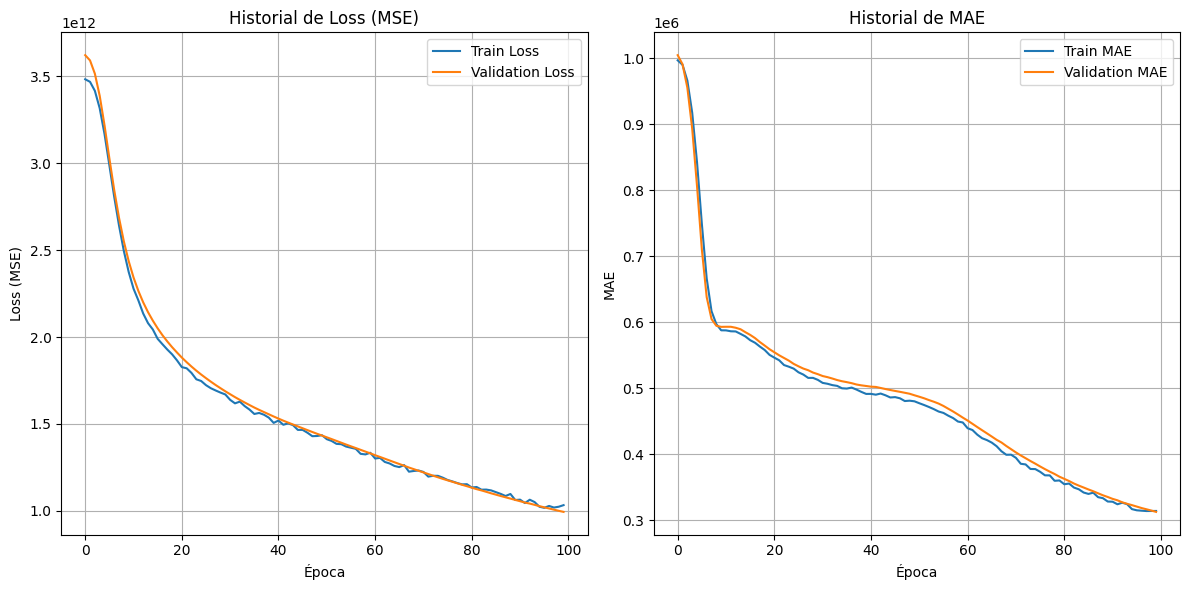

In [27]:
if history:
    graficar_historial_entrenamiento_regresion(history)


--- Evaluación del modelo ---
Test Loss (MSE): 1080436523008.0000
Test MAE: 309579.9688
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Manual MSE: 1080436588544.0000
Manual MAE: 309579.9062
R2 Score: 0.5822

--- Visualización de predicciones ---


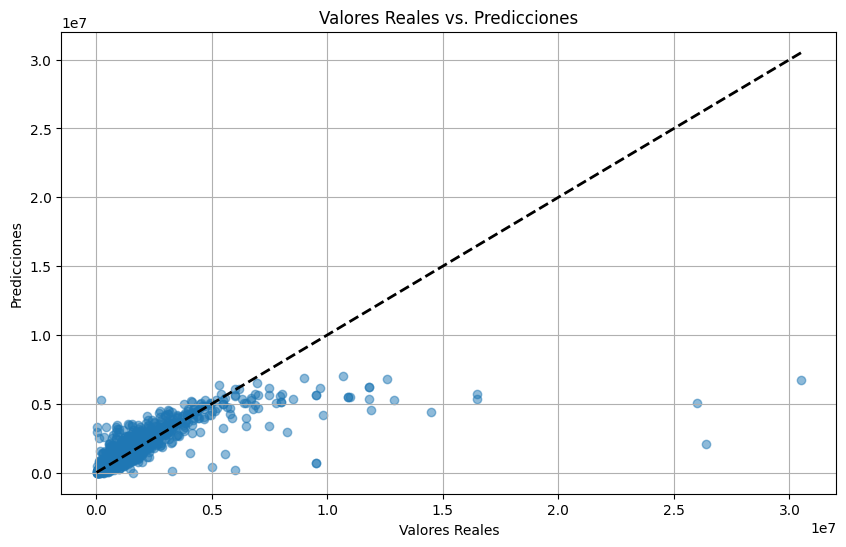


--- Histograma de Residuos ---


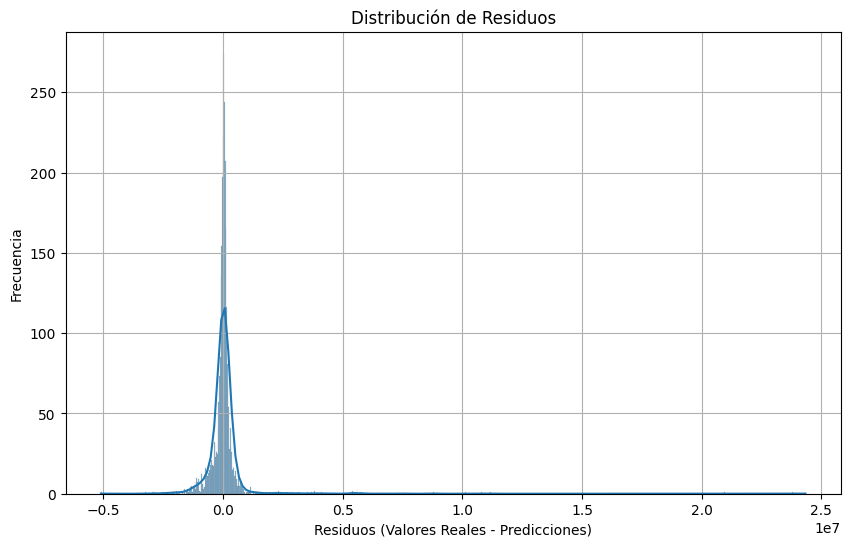


--- Residuos vs. Predicciones ---


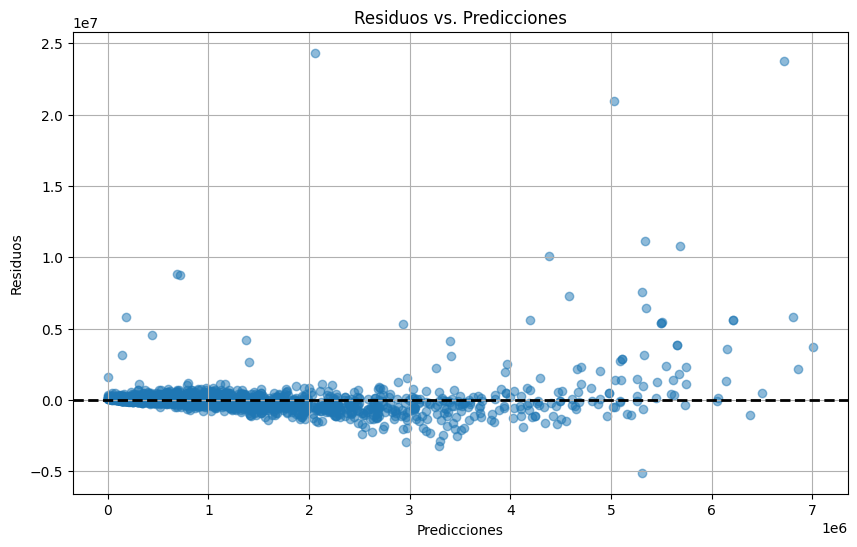


--- Ejemplos de Predicciones ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
       Year  kmDriven          Brand        model    FuelType  AskPrice Real  \
7041   2020   96000.0  Maruti Suzuki       Ertiga  Hybrid/CNG        1035000   
9129   2020   45000.0            Kia       Seltos      Diesel        1645000   
13416  2013   64205.0        Hyundai          i10      hybrid         249999   
305    2023    4000.0       Mahindra       XUV700      Petrol        2100000   
46     2020   94856.0  Maruti Suzuki  Swift-Dzire      Petrol         690000   

       AskPrice Predicha    Diferencia  
7041        8.461278e+05  188872.25000  
9129        1.030579e+06  614420.75000  
13416       2.865980e+05  -36598.96875  
305         2.848764e+06 -748764.00000  
46          6.927748e+05   -2774.75000  


In [28]:
# prompt: genera evaluar_y_visualizar_regresion

def evaluar_y_visualizar_regresion(model, X_test_processed, y_test, preprocessor, X_test_original):
    """
    Evalúa un modelo de regresión y visualiza los resultados.

    Args:
        model: El modelo entrenado.
        X_test_processed: Datos de prueba preprocesados.
        y_test: Etiquetas de prueba reales.
        preprocessor: El objeto preprocessor utilizado para transformar los datos.
        X_test_original: Datos de prueba originales antes del preprocesamiento.
    """
    # 1. Evaluación del modelo
    print("\n--- Evaluación del modelo ---")
    loss, mae = model.evaluate(X_test_processed, y_test, verbose=0)
    print(f'Test Loss (MSE): {loss:.4f}')
    print(f'Test MAE: {mae:.4f}')

    y_pred = model.predict(X_test_processed).flatten()

    mse = mean_squared_error(y_test, y_pred)
    mae_score = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Manual MSE: {mse:.4f}')
    print(f'Manual MAE: {mae_score:.4f}')
    print(f'R2 Score: {r2:.4f}')

    # 2. Visualización de predicciones vs. valores reales
    print("\n--- Visualización de predicciones ---")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Valores Reales vs. Predicciones')
    plt.grid(True)
    plt.show()

    # 3. Histograma de residuos
    print("\n--- Histograma de Residuos ---")
    residuos = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuos, kde=True)
    plt.xlabel('Residuos (Valores Reales - Predicciones)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')
    plt.grid(True)
    plt.show()

    # 4. Análisis de residuos vs. predicciones
    print("\n--- Residuos vs. Predicciones ---")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuos, alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', lw=2)
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Residuos vs. Predicciones')
    plt.grid(True)
    plt.show()

    # 5. Predicciones en algunos ejemplos del conjunto de prueba (opcional)
    print("\n--- Ejemplos de Predicciones ---")
    # Seleccionar algunas filas al azar del X_test original
    sample_indices = X_test_original.sample(5, random_state=42).index
    sample_X_original = X_test_original.loc[sample_indices]
    sample_y_real = y_test.loc[sample_indices]

    # Preprocesar los datos de ejemplo
    sample_X_processed = preprocessor.transform(sample_X_original)

    # Realizar predicciones
    sample_y_pred = model.predict(sample_X_processed).flatten()

    # Crear un DataFrame para mostrar los resultados
    results_df = sample_X_original.copy()
    results_df['AskPrice Real'] = sample_y_real
    results_df['AskPrice Predicha'] = sample_y_pred
    results_df['Diferencia'] = results_df['AskPrice Real'] - results_df['AskPrice Predicha']

    print(results_df)

# Llamar a la función después de entrenar el modelo
evaluar_y_visualizar_regresion(model, X_test_processed, y_test, preprocessor, X_test)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 1080436588544.00
Test MAE: 309579.91
Test R² Score: 0.58


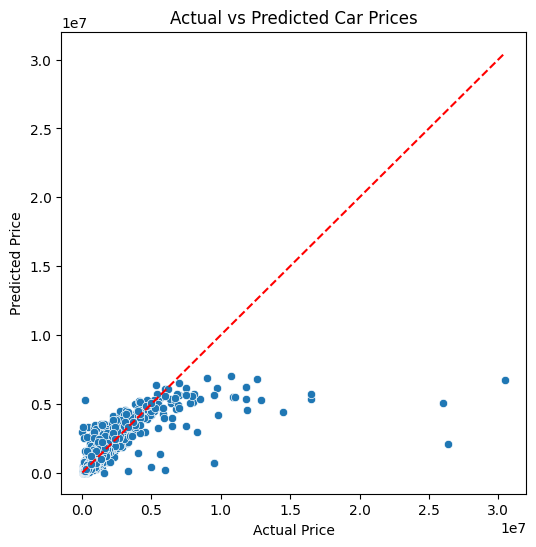

In [23]:
y_pred = model.predict(X_test_processed).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.2f}")

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()
